### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@dev`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


#### Install py4j
In addition install py4j v0.10.9.1-mm from my github clone
`git clone https://github.com/sedgewickmm18/py4j`

Install with
```
cd py4j-java
./gradlew clean assemble # build java jars
cd ..
pip install .  # install python and jars
```

#### Install timeseries-insights
Checkout WatFore forecasting library first

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/WatFore`

then timeseries-insights

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/timeseries-insights`

Finally apply a patch for allow for a callback server IP other than 127.0.0.1

`curl https://raw.githubusercontent.com/sedgewickmm18/tsi/master/context.py.patch | patch -p1`


Build WatFore
```
cd WatFore
mvn clean install -DskipTests
```

Build timeseries-insights
```
cd ../timeseries-insights
mvn clean install -DskipTests
```

Build the python distribution of tspy
```
cd python
python setup.py sdist
```

Install it

`pip install dist/tspy-2.0.5.0.tar.gz`


#### Run timeseries-insights as docker container

`docker run -p 25332:25332 -p 25333:25333 sedgewickmm18/tsi`

* port 25333 exposes the default port for the java server
* port 25332 allows for optional ssh based port forwarding (should not be necessary)

The patch above allows for callback server IP addresses other than 127.0.0.1, i.e. the python client that also acts as callback server for python lambda processing can listen to a docker bridge IP address. In my case I'm running it from my laptop on `172.17.0.1` while the container with the java process has IP address `172.17.0.2`.

##### Caveat:

The java process attempts to listen to IPv4 **and** IPv6 addresses so have to enable IPv6 for your docker bridge with

`sudo vi /etc/docker/daemon.json`

so that it looks similar to

```
{
    "insecure-registries" : ["localhost:32000"],
    "ipv6": true,
    "fixed-cidr-v6": "2001:db8:1::/64"
}
```

Then restart the docker daemon with

`systemctl restart docker`

and check with

`docker network inspect bridge`

In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# setting to make life easier
Temperature='Vx'



In [3]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-10-14T15:08:11.506 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [4]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('AllOfArmstark.csv', index_col=False, parse_dates=['timestamp'])

#df_i['entity']='MyRoom'
#df_i[Temperature]=df_i['value'] + 20
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

,,Vx,Vy,Vz,Ap,As,speed
entity,timestamp,,,,,,
04714B604101,2020-01-01 00:02:12.713,-0.0625,-0.0908,-1.0332,2.3650,1.036,1.042
04714B6046D5,2020-01-01 00:02:25.928,-0.0439,-0.0137,-1.0029,2.2904,1.036,1.036


In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['04714B6046D5']]
df_inputm2.reset_index(level=[0], inplace=True)

# predicted just means normalized - need to modify the BaseEstimatorFunction superclass


In [6]:
# start the callback server

#from tspy import TSContext
import tspy
from tspy.data_structures.context import TSContext 
from py4j.java_gateway import JavaGateway, GatewayParameters, CallbackServerParameters


gateway = JavaGateway(gateway_parameters=GatewayParameters(address=u'172.17.0.2',
                                  auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA='),
            callback_server_parameters=CallbackServerParameters(daemonize=True,port=25334,address=u'172.17.0.1',
                         auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA=',daemonize_connections=True))



2020-10-14T15:08:42.949 INFO py4j.java_gateway.run Callback Server Starting
2020-10-14T15:08:42.950 INFO py4j.java_gateway.run Socket listening on ('172.17.0.1', 25334)


In [7]:
df_i

Vx      Vy      Vz      Ap     As  \
entity       timestamp                                                        
04714B604101 2020-01-01 00:02:12.713 -0.0625 -0.0908 -1.0332  2.3650  1.036   
04714B6046D5 2020-01-01 00:02:25.928 -0.0439 -0.0137 -1.0029  2.2904  1.036   
04714B604101 2020-01-01 00:03:12.713  0.0361  0.0078 -0.9141  2.3650  1.036   
04714B6046D5 2020-01-01 00:03:25.928 -0.0430 -0.0205 -0.9023  2.2904  1.036   
04714B604101 2020-01-01 00:04:12.713  0.1172 -0.0332 -0.9756  2.3650  1.036   
...                                      ...     ...     ...     ...    ...   
             2020-01-31 12:10:16.047 -0.0088 -0.0361 -0.9160  2.2800  1.032   
04714B6046D5 2020-01-31 12:10:23.501 -0.0879 -0.0322 -0.8750  2.2760  1.037   
             2020-01-31 12:11:23.501  0.0596 -0.0166 -0.9795  2.2744  1.037   
             2020-01-31 12:12:23.501  0.0801 -0.0215 -1.0166  2.2744  1.037   
             2020-01-31 12:13:23.501 -0.0957  0.0029 -0.9854  2.2744  1.037   

                                      speed  
entity       timestamp                       
04714B604101 2020-01-01 00:02:12.713  1.042  
04714B6046D5 2020-01-01 00:02:25.928  1.036  
04714B604101 2020-01-01 00:03:12.713  1.042  
04714B6046D5 2020-01-01 00:03:25.928  1.036  
04714B604101 2020-01-01 00:04:12.713  1.042  
...                                     ...  
             2020-01-31 12:10:16.047  1.033  
04714B6046D5 2020-01-31 12:10:23.501  1.037  
             2020-01-31 12:11:23.501  1.037  
             2020-01-31 12:12:23.501  1.037  
             2020-01-31 12:13:23.501  1.037  

[258495 rows x 6 columns]

In [8]:
import datetime

df = df_i.reset_index()[['entity','timestamp','Vx']] #['entity'=='04714B6046D5']
df = df[df['entity']=='04714B6046D5']


tsc = TSContext(gateway=gateway, jvm=gateway.jvm, daemonize=True)

model = tspy.forecasters.arima(500)

model_map = {
        '04714B6046D5': model,
}

In [9]:
df

,entity,timestamp,Vx
1,04714B6046D5,2020-01-01 00:02:25.928,-0.0439
3,04714B6046D5,2020-01-01 00:03:25.928,-0.0430
5,04714B6046D5,2020-01-01 00:04:25.928,0.0039
7,04714B6046D5,2020-01-01 00:05:25.928,0.0283
9,04714B6046D5,2020-01-01 00:06:25.928,-0.0771
...,...,...,...
258489,04714B6046D5,2020-01-31 12:09:23.501,0.0293
258491,04714B6046D5,2020-01-31 12:10:23.501,-0.0879
258492,04714B6046D5,2020-01-31 12:11:23.501,0.0596
258493,04714B6046D5,2020-01-31 12:12:23.501,0.0801


In [10]:
dfs = df.tail(20000)
mts_raw = tsc.multi_time_series\
        .df_observations(dfs, dfs.keys()[0], dfs.keys()[1], dfs.keys()[2], granularity=datetime.timedelta(milliseconds=1))\
        .with_trs(granularity=datetime.timedelta(minutes=1)) \
        .transform(tsc.duplicate_transforms.combine_duplicate_time_ticks(lambda x: float(sum(x) / len(x))))

In [11]:
dfss = mts_raw.to_df()

2020-10-14T15:09:18.408 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-10-14T15:09:18.409 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.414 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.416 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.417 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.418 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.419 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.421 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.422 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.423 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.424 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.425 INFO py4j.java_gate

2020-10-14T15:09:18.506 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.506 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.507 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.508 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.509 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.510 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.511 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.515 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.516 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.516 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.518 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.519 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:18.608 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.609 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.610 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.611 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.612 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.613 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.614 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.615 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.615 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.616 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.617 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.618 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:18.704 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.705 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.706 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.707 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.708 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.709 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.710 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.711 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.712 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.713 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.716 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.718 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:18.796 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.796 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.797 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.798 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.799 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.800 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.801 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.802 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.802 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.803 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.804 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.805 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:18.885 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.886 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.886 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.887 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.890 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.891 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.892 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.892 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.893 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.894 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.895 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.895 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:18.977 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.978 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.979 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.980 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.980 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.981 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.982 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.983 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.984 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.985 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.986 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:18.987 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.072 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.076 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.077 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.078 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.079 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.080 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.081 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.082 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.082 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.083 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.084 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.085 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.170 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.171 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.171 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.172 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.173 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.174 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.175 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.176 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.177 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.178 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.178 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.179 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.260 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.261 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.262 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.262 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.263 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.264 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.265 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.266 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.267 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.267 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.268 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.269 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.346 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.346 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.347 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.348 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.349 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.350 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.350 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.351 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.352 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.352 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.353 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.354 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.429 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.430 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.431 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.432 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.433 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.434 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.435 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.436 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.436 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.437 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.438 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.440 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.546 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.547 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.548 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.549 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.551 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.552 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.553 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.555 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.556 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.557 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.559 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.560 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.752 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.754 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.755 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.756 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.758 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.760 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.762 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.763 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.764 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.765 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.767 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.771 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:19.900 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.901 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.902 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.904 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.905 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.906 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.908 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.909 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.911 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.912 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.913 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:19.914 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.031 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.032 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.039 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.040 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.041 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.043 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.044 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.045 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.047 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.048 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.049 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.051 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.179 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.180 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.182 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.183 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.184 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.186 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.187 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.189 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.190 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.192 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.194 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.195 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.326 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.327 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.329 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.330 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.331 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.332 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.334 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.335 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.336 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.338 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.339 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.340 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.461 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.463 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.464 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.466 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.467 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.469 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.470 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.472 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.473 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.474 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.475 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.476 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.606 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.607 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.608 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.610 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.611 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.613 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.614 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.615 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.616 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.618 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.619 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.621 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.742 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.743 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.744 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.746 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.747 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.748 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.750 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.751 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.752 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.754 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.755 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.756 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.856 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.857 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.857 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.858 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.859 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.859 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.860 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.861 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.861 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.862 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.863 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.864 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:20.954 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.954 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.955 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.956 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.958 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.959 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.960 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.961 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.962 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.962 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.963 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:20.964 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.041 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.042 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.043 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.043 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.044 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.045 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.046 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.047 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.048 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.048 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.049 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.050 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.132 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.133 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.134 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.135 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.136 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.137 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.138 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.139 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.140 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.141 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.142 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.143 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.224 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.225 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.226 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.227 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.228 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.230 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.233 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.235 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.236 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.238 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.239 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.240 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.325 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.326 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.327 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.328 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.329 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.329 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.330 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.331 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.331 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.332 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.333 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.334 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.422 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.423 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.424 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.425 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.425 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.426 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.427 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.428 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.429 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.430 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.431 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.432 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.526 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.527 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.528 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.529 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.530 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.531 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.531 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.532 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.533 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.534 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.535 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.536 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.617 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.618 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.619 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.620 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.621 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.621 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.623 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.624 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.625 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.626 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.626 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.627 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.715 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.716 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.716 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.717 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.718 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.718 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.719 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.720 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.721 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.722 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.723 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.724 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.797 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.797 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.798 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.799 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.800 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.801 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.802 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.803 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.806 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.808 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.809 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.809 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:21.893 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.894 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.895 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.896 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.897 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.898 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.900 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.901 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.902 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.903 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.904 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:21.905 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.001 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.002 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.003 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.004 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.006 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.007 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.008 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.009 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.011 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.012 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.013 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.018 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.115 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.116 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.117 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.118 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.119 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.120 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.121 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.122 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.123 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.124 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.126 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.126 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.225 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.226 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.227 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.228 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.229 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.230 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.232 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.233 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.234 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.235 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.236 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.241 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.345 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.346 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.347 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.348 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.349 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.350 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.351 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.353 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.354 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.355 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.356 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.357 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.456 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.457 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.459 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.460 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.462 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.463 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.464 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.465 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.467 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.471 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.472 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.473 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.563 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.564 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.565 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.566 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.566 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.567 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.568 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.569 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.570 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.571 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.572 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.573 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.650 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.651 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.652 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.655 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.656 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.657 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.658 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.659 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.660 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.660 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.661 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.662 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.748 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.749 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.750 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.751 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.752 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.753 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.754 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.756 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.757 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.757 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.758 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.759 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.841 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.842 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.843 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.844 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.845 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.845 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.846 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.847 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.848 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.849 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.850 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.851 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:22.929 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.930 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.931 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.932 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.933 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.934 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.935 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.936 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.936 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.937 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.938 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:22.939 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.026 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.027 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.027 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.028 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.029 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.030 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.031 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.032 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.033 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.033 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.034 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.035 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.106 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.107 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.108 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.109 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.109 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.110 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.111 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.112 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.113 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.113 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.114 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.115 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.192 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.192 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.193 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.194 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.194 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.195 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.196 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.196 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.197 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.198 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.199 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.200 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.274 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.275 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.276 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.277 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.277 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.280 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.281 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.282 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.283 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.284 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.285 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.286 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.379 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.380 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.381 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.382 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.384 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.385 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.386 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.387 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.388 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.388 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.389 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.475 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.477 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.478 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.479 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.480 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.481 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.482 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.483 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.484 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.487 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.488 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.489 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.581 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.582 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.583 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.584 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.585 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.586 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.587 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.588 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.588 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.589 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.590 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.591 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.669 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.670 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.671 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.672 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.672 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.673 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.676 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.677 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.678 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.679 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.680 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.681 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.767 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.768 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.769 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.770 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.771 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.772 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.773 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.774 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.775 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.776 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.777 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.778 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.861 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.862 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.866 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.868 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.869 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.869 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.870 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.871 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.872 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.873 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.874 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.875 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:23.960 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.961 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.962 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.962 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.963 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.965 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.965 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.966 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.967 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.968 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.969 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:23.970 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.060 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.065 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.066 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.067 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.068 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.070 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.071 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.072 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.074 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.075 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.076 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.077 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.169 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.170 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.171 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.172 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.172 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.173 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.174 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.174 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.175 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.176 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.176 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.177 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.275 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.276 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.277 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.278 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.279 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.280 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.281 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.281 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.282 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.283 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.285 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.285 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.372 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.373 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.375 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.376 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.377 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.378 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.379 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.381 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.382 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.382 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.384 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.385 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.490 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.491 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.492 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.493 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.494 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.495 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.496 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.497 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.498 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.499 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.500 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.501 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.598 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.599 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.600 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.602 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.603 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.604 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.605 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.605 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.606 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.607 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.608 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.609 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.700 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.701 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.702 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.703 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.704 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.705 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.706 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.707 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.707 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.708 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.710 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.710 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.788 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.789 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.789 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.790 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.791 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.792 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.793 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.793 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.794 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.795 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.797 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.798 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.879 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.879 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.880 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.881 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.882 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.883 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.884 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.885 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.886 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.887 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.887 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.888 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:24.976 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.977 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.978 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.979 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.980 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.980 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.981 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.985 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.986 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.989 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.990 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:24.991 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:25.080 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.081 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.082 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.083 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.084 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.085 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.087 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.088 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.089 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.089 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.090 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.091 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:25.179 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.180 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.181 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.182 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.183 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.183 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.184 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.189 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.190 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.191 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.192 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.193 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:25.277 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.278 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.279 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.280 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.281 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.282 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.282 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.283 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.284 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.285 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.285 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.286 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:25.372 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.373 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.377 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.378 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.379 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.380 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.381 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.382 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.384 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.385 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.385 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:25.467 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.468 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.469 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.470 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.471 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.472 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.473 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.474 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.475 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.476 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.477 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.478 INFO py4j.java_gateway.run Rec

2020-10-14T15:09:25.615 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.616 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.617 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.618 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.619 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.621 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.622 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.623 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.624 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.625 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.625 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T15:09:25.626 INFO py4j.java_gateway.run Rec

In [12]:
dfss

,timestamp,key,value
0,26334532,04714B6046D5,-0.020500
1,26334533,04714B6046D5,-0.009067
2,26334534,04714B6046D5,0.026700
3,26334535,04714B6046D5,0.069300
4,26334536,04714B6046D5,0.015300
...,...,...,...
6677,26341209,04714B6046D5,0.029300
6678,26341210,04714B6046D5,-0.087900
6679,26341211,04714B6046D5,0.059600
6680,26341212,04714B6046D5,0.080100


In [13]:
model.update_model(dfss['timestamp'].astype(int).tolist(), dfss['value'].tolist())
#model.update_model(mts_raw)

2020-10-14T15:09:46.712 INFO py4j.java_gateway.run Received command g on object id p102
2020-10-14T15:09:46.713 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p102


In [14]:
model

Forecasting Model
  Algorithm: RegularARIMAAlgorithm [armaAlgorithm=RegularARMAAlgorithm [dataHistory=WeightedHistory [weights=[-0.20176167052768776, -0.5883934830656194], history=com.ibm.watson.pm.util.CircularBuffer@c2a4c920, historyLength=2, dataCount=6682], errorHistory=WeightedHistory [weights=null, history=null, historyLength=0, dataCount=0], dataMean=0.008636178861788515, minTrainingData=80, pMin=0, pMax=5, qMin=0, qMax=5, forceModel=false], differencer=null, minTrainingData=82, diffOrder=-1]

In [15]:
forecasts = mts_raw.forecast(100, model_map, confidence=0.97)

In [16]:
df2 = mts_raw.to_df()

In [17]:
df2.describe()

,timestamp,value
count,6.682000e+03,6682.000000
mean,2.633787e+07,0.007490
std,1.929072e+03,0.026912
min,2.633453e+07,-0.129233
25%,2.633620e+07,-0.010067
50%,2.633787e+07,0.007800
75%,2.633954e+07,0.024400
max,2.634121e+07,0.151367


In [18]:
for k, series in forecasts.items():
    for k2 in series:
        print(k2)
        print(k2.value)
        ser = pd.Series
        df2 = df2.append({'timestamp': k2.time_tick, 'key': k, 'value': k2.value['value']}, ignore_index=True)

2020-10-14T15:10:19.447 INFO py4j.java_gateway.run Received command c on object id p101
2020-10-14T15:10:19.449 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-10-14T15:10:19.451 INFO py4j.java_gateway.run Received command c on object id p1
TimeStamp: 26341214     Value: {value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-10-14T15:10:19.452 INFO py4j.java_gateway.run Received command c on object id p1
{value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-10-14T15:10:19.454 INFO py4j.java_gateway.run Received command c on object id p1
2020-10-14T15:10:19.459 INFO py4j.java_gateway.run Received command c on object id p102
2020-10-14T15:10:19.460 INFO py4j.java_gateway.run Received command c on object id p2
TimeStamp: 26341215     Value: {value=0.07426345874386522, lower_bound=0.016315441143630767, upper_bou

2020-10-14T15:10:19.545 INFO py4j.java_gateway.run Received command c on object id p114
2020-10-14T15:10:19.546 INFO py4j.java_gateway.run Received command c on object id p14
TimeStamp: 26341227     Value: {value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-10-14T15:10:19.547 INFO py4j.java_gateway.run Received command c on object id p14
{value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-10-14T15:10:19.548 INFO py4j.java_gateway.run Received command c on object id p14
2020-10-14T15:10:19.552 INFO py4j.java_gateway.run Received command c on object id p115
2020-10-14T15:10:19.553 INFO py4j.java_gateway.run Received command c on object id p15
TimeStamp: 26341228     Value: {value=0.006534406915676166, lower_bound=-0.051476179480886466, upper_bound=0.0645449933122388, error=0.026731875774159662}
2020-10-14T15:10:19.554 INFO py4j.java_gat

2020-10-14T15:10:19.633 INFO py4j.java_gateway.run Received command c on object id p27
TimeStamp: 26341240     Value: {value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239163}
2020-10-14T15:10:19.634 INFO py4j.java_gateway.run Received command c on object id p27
{value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239163}
2020-10-14T15:10:19.635 INFO py4j.java_gateway.run Received command c on object id p27
2020-10-14T15:10:19.639 INFO py4j.java_gateway.run Received command c on object id p128
2020-10-14T15:10:19.639 INFO py4j.java_gateway.run Received command c on object id p28
TimeStamp: 26341241     Value: {value=0.00870210523513361, lower_bound=-0.04935247333772264, upper_bound=0.06675668380798987, error=0.026752147822155813}
2020-10-14T15:10:19.640 INFO py4j.java_gateway.run Received command c on object id p28
{value=0.00870210523513361, lower_bound=-0

TimeStamp: 26341253     Value: {value=0.00863566720869493, lower_bound=-0.04936167929226491, upper_bound=0.06663301370965477, error=0.026725774693882744}
2020-10-14T15:10:19.717 INFO py4j.java_gateway.run Received command c on object id p40
{value=0.00863566720869493, lower_bound=-0.04936167929226491, upper_bound=0.06663301370965477, error=0.026725774693882744}
2020-10-14T15:10:19.718 INFO py4j.java_gateway.run Received command c on object id p40
2020-10-14T15:10:19.723 INFO py4j.java_gateway.run Received command c on object id p141
2020-10-14T15:10:19.724 INFO py4j.java_gateway.run Received command c on object id p41
TimeStamp: 26341254     Value: {value=0.00863415475391532, lower_bound=-0.04936647878217729, upper_bound=0.06663478829000793, error=0.02672728939353142}
2020-10-14T15:10:19.725 INFO py4j.java_gateway.run Received command c on object id p41
{value=0.00863415475391532, lower_bound=-0.04936647878217729, upper_bound=0.06663478829000793, error=0.02672728939353142}
2020-10-14T1

{value=0.008636207436751336, lower_bound=-0.049342494961307284, upper_bound=0.06661490983480996, error=0.026717183299214377}
2020-10-14T15:10:19.812 INFO py4j.java_gateway.run Received command c on object id p53
2020-10-14T15:10:19.817 INFO py4j.java_gateway.run Received command c on object id p154
2020-10-14T15:10:19.818 INFO py4j.java_gateway.run Received command c on object id p54
TimeStamp: 26341267     Value: {value=0.008636239592060281, lower_bound=-0.04934655963222196, upper_bound=0.06661903881634253, error=0.026719071158939317}
2020-10-14T15:10:19.820 INFO py4j.java_gateway.run Received command c on object id p54
{value=0.008636239592060281, lower_bound=-0.04934655963222196, upper_bound=0.06661903881634253, error=0.026719071158939317}
2020-10-14T15:10:19.821 INFO py4j.java_gateway.run Received command c on object id p54
2020-10-14T15:10:19.825 INFO py4j.java_gateway.run Received command c on object id p155
2020-10-14T15:10:19.826 INFO py4j.java_gateway.run Received command c on

2020-10-14T15:10:19.911 INFO py4j.java_gateway.run Received command c on object id p167
2020-10-14T15:10:19.912 INFO py4j.java_gateway.run Received command c on object id p67
TimeStamp: 26341280     Value: {value=0.008636177086363852, lower_bound=-0.0493691778126087, upper_bound=0.0666415319853364, error=0.026729465046180897}
2020-10-14T15:10:19.913 INFO py4j.java_gateway.run Received command c on object id p67
{value=0.008636177086363852, lower_bound=-0.0493691778126087, upper_bound=0.0666415319853364, error=0.026729465046180897}
2020-10-14T15:10:19.914 INFO py4j.java_gateway.run Received command c on object id p67
2020-10-14T15:10:19.919 INFO py4j.java_gateway.run Received command c on object id p168
2020-10-14T15:10:19.920 INFO py4j.java_gateway.run Received command c on object id p68
TimeStamp: 26341281     Value: {value=0.008636179974272878, lower_bound=-0.049373362100194024, upper_bound=0.06664572204873978, error=0.02673139453978047}
2020-10-14T15:10:19.921 INFO py4j.java_gateway

2020-10-14T15:10:20.001 INFO py4j.java_gateway.run Received command c on object id p80
TimeStamp: 26341293     Value: {value=0.00863617891211564, lower_bound=-0.04931183530539649, upper_bound=0.06658419312962777, error=0.02670304186950195}
2020-10-14T15:10:20.002 INFO py4j.java_gateway.run Received command c on object id p80
{value=0.00863617891211564, lower_bound=-0.04931183530539649, upper_bound=0.06658419312962777, error=0.02670304186950195}
2020-10-14T15:10:20.003 INFO py4j.java_gateway.run Received command c on object id p80
2020-10-14T15:10:20.006 INFO py4j.java_gateway.run Received command c on object id p181
2020-10-14T15:10:20.007 INFO py4j.java_gateway.run Received command c on object id p81
TimeStamp: 26341294     Value: {value=0.008636178821147929, lower_bound=-0.04927867937238252, upper_bound=0.06655103701467838, error=0.02668776323211352}
2020-10-14T15:10:20.008 INFO py4j.java_gateway.run Received command c on object id p81
{value=0.008636178821147929, lower_bound=-0.0492

TimeStamp: 26341306     Value: {value=0.008636178860416672, lower_bound=-0.04927509748773246, upper_bound=0.06654745520856581, error=0.02668611268086549}
2020-10-14T15:10:20.092 INFO py4j.java_gateway.run Received command c on object id p93
{value=0.008636178860416672, lower_bound=-0.04927509748773246, upper_bound=0.06654745520856581, error=0.02668611268086549}
2020-10-14T15:10:20.093 INFO py4j.java_gateway.run Received command c on object id p93
2020-10-14T15:10:20.096 INFO py4j.java_gateway.run Received command c on object id p194
2020-10-14T15:10:20.097 INFO py4j.java_gateway.run Received command c on object id p94
TimeStamp: 26341307     Value: {value=0.008636178863221967, lower_bound=-0.049277986875438023, upper_bound=0.06655034460188196, error=0.026687444141776286}
2020-10-14T15:10:20.098 INFO py4j.java_gateway.run Received command c on object id p94
{value=0.008636178863221967, lower_bound=-0.049277986875438023, upper_bound=0.06655034460188196, error=0.026687444141776286}
2020-1

Text(0, 0.5, 'Pump Vibration')

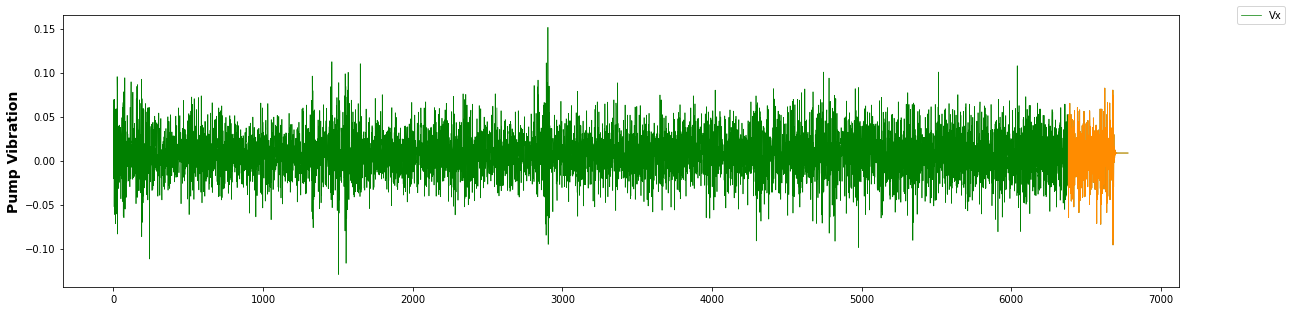

2020-10-14T15:11:07.014 INFO py4j.java_gateway.run Received command  on object id 
2020-10-14T15:11:07.015 INFO py4j.java_gateway.run Received command  on object id 
2020-10-14T15:11:07.017 INFO py4j.java_gateway.close Closing down callback connection
2020-10-14T15:11:07.019 INFO py4j.java_gateway.close Closing down callback connection
2020-10-14T15:14:28.036 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-10-14T15:14:28.037 INFO py4j.java_gateway.run Received command g on object id p104
2020-10-14T15:14:28.038 INFO py4j.java_gateway.run Received command g on object id p103
2020-10-14T15:14:28.038 INFO py4j.java_gateway.run Received command g on object id p102
2020-10-14T15:14:28.039 INFO py4j.java_gateway.run Received command g on object id p101
2020-10-14T15:14:28.039 INFO py4j.java_gateway.run Received command g on object id p156
2020-10-14T15:14:28.040 INFO py4j.java_gateway.run Received command g on object id p154
2020-10-14T15:14:28.040 INFO py4j.jav

2020-10-14T15:14:28.075 INFO py4j.java_gateway.run Received command g on object id p165
2020-10-14T15:14:28.076 INFO py4j.java_gateway.run Received command g on object id p164
2020-10-14T15:14:28.076 INFO py4j.java_gateway.run Received command g on object id p163
2020-10-14T15:14:28.076 INFO py4j.java_gateway.run Received command g on object id p162
2020-10-14T15:14:28.077 INFO py4j.java_gateway.run Received command g on object id p161
2020-10-14T15:14:28.077 INFO py4j.java_gateway.run Received command g on object id p160
2020-10-14T15:14:28.078 INFO py4j.java_gateway.run Received command g on object id p159
2020-10-14T15:14:28.078 INFO py4j.java_gateway.run Received command g on object id p158
2020-10-14T15:14:28.079 INFO py4j.java_gateway.run Received command g on object id p157
2020-10-14T15:15:07.014 INFO py4j.java_gateway.run Received command  on object id 
2020-10-14T15:15:07.014 INFO py4j.java_gateway.close Closing down callback connection


In [19]:
dftail = df2.tail(400)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot(df2.index, df2['value'],linewidth=0.7,color='green',label=Temperature)
ax.plot(dftail.index, dftail['value'],linewidth=0.9,color='darkorange')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Pump Vibration',fontsize=14,weight="bold")